# Query para Churn Semestral de 2015 até 2025 (anomalias)

✅ Sucesso! Os dados foram carregados em 'df_churn_semestral'.
------------------------------
  periodo_semestral  clientes_inicio_semestre  total_churn_no_semestre  \
0           2015-S1                      4314                      496   
1           2015-S2                      4427                      452   
2           2016-S1                      4679                      480   
3           2016-S2                      4814                      468   
4           2017-S1                      4562                      388   
5           2017-S2                      4367                      354   
6           2018-S1                      4244                      358   
7           2018-S2                      4194                      357   
8           2019-S1                      4189                      311   
9           2019-S2                      4262                      313   

   churn_rate_semestral_percentual   analise_saude  
0                            11.50  CRÍ

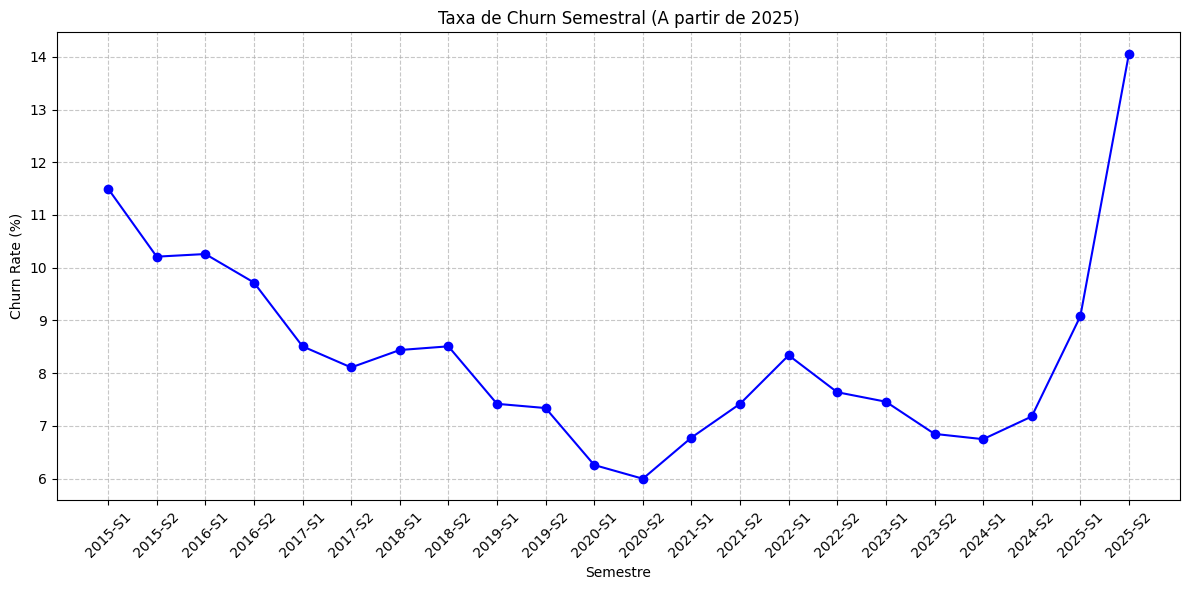

In [2]:
import os
import pandas as pd
import urllib.parse
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt

# 1. Carregar variáveis de ambiente
load_dotenv()

# 2. Configuração das credenciais com tratamento de caracteres especiais
user     = os.getenv("PROD_POSTGRES_USERNAME")
password = urllib.parse.quote_plus(os.getenv("PROD_POSTGRES_PASSWORD"))
host     = os.getenv("PROD_POSTGRES_HOST")
database = os.getenv("PROD_POSTGRES_DATABASE")
port     = os.getenv("POST_PORT", "5432")

conn_url = f"postgresql://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(conn_url)

# 3. Definição da Query SQL de Churn Semestral (Início em 2006)
sql_query = """
with base_contratos as (
    select
        distinct
        c.nr_central_sigma,
        ccc.codigo_contrato,
        ccc.data_pedido as data_inicio,
        ccc.data_rescisao,
        (
            select mcc.situacao
            from movimento_contratos_cli mcc
            where mcc.codigo_contrato = ccc.codigo_contrato
              and mcc.situacao <> 7
            order by mcc.data_conclusao desc
            limit 1
        ) as situacao_movimento
    from clientes c
    inner join cab_contratos_cli ccc on ccc.codigo_cliente = c.codigo_cliente
),

clientes_com_contrato_ativo as (
    select distinct nr_central_sigma
    from base_contratos
    where data_rescisao is null
),

churn_por_cliente as (
    select
        bc.nr_central_sigma,
        MAX(bc.data_rescisao) as data_churn
    from base_contratos bc
    where bc.data_rescisao is not null
      and bc.nr_central_sigma not in (select nr_central_sigma from clientes_com_contrato_ativo)
    group by bc.nr_central_sigma
),

data_minima as (
    -- Alterado para iniciar em 2015 e definir o teto em 2025
    select 
        '2015-01-01'::date as inicio_historico,
        '2025-12-31'::date as fim_historico
),

churn_semestral as (
    select
        date_trunc('year', ch.data_churn) + (interval '6 months' * floor((extract(month from ch.data_churn) - 1) / 6)) as semestre_churn,
        COUNT(distinct ch.nr_central_sigma) as clientes_churn
    from churn_por_cliente ch
    group by 1
),

clientes_ativos_inicio_semestre as (
    select
        ss.semestre,
        COUNT(distinct bc.nr_central_sigma) as total_clientes_inicio
    from (
        select generate_series(
            (select inicio_historico from data_minima),
            (select fim_historico from data_minima),
            '6 months'
        )::date as semestre
    ) ss
    cross join base_contratos bc
    where bc.data_inicio < ss.semestre
      and (bc.data_rescisao is null or bc.data_rescisao >= ss.semestre)
    group by ss.semestre
)

select
    concat(
        extract(year from cas.semestre), 
        case when extract(month from cas.semestre) <= 6 then '-S1' else '-S2' end
    ) as periodo_semestral,
    cas.total_clientes_inicio as clientes_inicio_semestre,
    coalesce(cs.clientes_churn, 0) as total_churn_no_semestre,
    case
        when cas.total_clientes_inicio = 0 then 0
        else ROUND((coalesce(cs.clientes_churn, 0)::numeric / cas.total_clientes_inicio::numeric) * 100, 2)
    end as churn_rate_semestral_percentual,
    case 
        when (coalesce(cs.clientes_churn, 0)::numeric / nullif(cas.total_clientes_inicio,0)::numeric) * 100 > 10 then 'CRÍTICO (>12%)'
        when (coalesce(cs.clientes_churn, 0)::numeric / nullif(cas.total_clientes_inicio,0)::numeric) * 100 > 7.5 then 'ALERTA'
        else 'DENTRO DA META'
    end as analise_saude
from clientes_ativos_inicio_semestre cas
left join churn_semestral cs on cas.semestre = cs.semestre_churn
where cas.total_clientes_inicio > 0
  and cas.semestre <= (select fim_historico from data_minima)
order by cas.semestre;
"""

# 4. Execução da consulta
try:
    with engine.connect() as conn:
        df_churn_semestral = pd.read_sql(text(sql_query), conn)

    print("✅ Sucesso! Os dados foram carregados em 'df_churn_semestral'.")
    print("-" * 30)
    print(df_churn_semestral.head(10)) # Exibe os primeiros 10 semestres 
    print("-" * 30)

    # 5. Visualização Básica
    plt.figure(figsize=(12, 6))
    plt.plot(df_churn_semestral['periodo_semestral'], df_churn_semestral['churn_rate_semestral_percentual'], marker='o', linestyle='-', color='b')
    plt.title('Taxa de Churn Semestral (A partir de 2025)')
    plt.xlabel('Semestre')
    plt.ylabel('Churn Rate (%)')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"❌ Erro ao executar consulta: {e}")

In [3]:
df_churn_semestral

,periodo_semestral,clientes_inicio_semestre,total_churn_no_semestre,churn_rate_semestral_percentual,analise_saude
0,2015-S1,4314,496,11.50,CRÍTICO (>12%)
1,2015-S2,4427,452,10.21,CRÍTICO (>12%)
2,2016-S1,4679,480,10.26,CRÍTICO (>12%)
3,2016-S2,4814,468,9.72,ALERTA
4,2017-S1,4562,388,8.51,ALERTA
5,2017-S2,4367,354,8.11,ALERTA
6,2018-S1,4244,358,8.44,ALERTA
7,2018-S2,4194,357,8.51,ALERTA
8,2019-S1,4189,311,7.42,DENTRO DA META
9,2019-S2,4262,313,7.34,DENTRO DA META


# Iniciando Analise Descritiva da Base Semestral

### Estudo da Volatilidade e Tendência Central Semestral

In [4]:
# Média e Mediana 
media_semestral = df_churn_semestral['churn_rate_semestral_percentual'].mean()
mediana_semestral = df_churn_semestral['churn_rate_semestral_percentual'].median()
print(mediana_semestral)
print(media_semestral)

7.875
8.356363636363637


In [6]:
# 1. Cálculo de métricas estatísticas detalhadas
media_semestral = df_churn_semestral['churn_rate_semestral_percentual'].mean()
mediana_semestral = df_churn_semestral['churn_rate_semestral_percentual'].median()
desvio_padrao = df_churn_semestral['churn_rate_semestral_percentual'].std()

print(f"Estatísticas de Churn:")
print(f"Média:   {media_semestral:.2f}%")
print(f"Mediana: {mediana_semestral:.2f}%")
print(f"Desvio Padrão: {desvio_padrao:.2f}% (Quanto menor, mais constante é o churn)")

# 2. Identificar os 3 piores semestres (Maiores Churns)
piores_semestres = df_churn_semestral.nlargest(3, 'churn_rate_semestral_percentual')
print("\n🚨 Top 3 Semestres com maior Churn:")
print(piores_semestres[['periodo_semestral', 'churn_rate_semestral_percentual']])

# 3. Criar uma coluna de variação (comparando com o semestre anterior)
df_churn_semestral['variacao_percentual'] = df_churn_semestral['churn_rate_semestral_percentual'].diff()

print("\n📈 Últimos 5 semestres analisados:")
print(df_churn_semestral[['periodo_semestral', 'churn_rate_semestral_percentual', 'analise_saude']].tail())

Estatísticas de Churn:
Média:   8.36%
Mediana: 7.88%
Desvio Padrão: 1.89% (Quanto menor, mais constante é o churn)

🚨 Top 3 Semestres com maior Churn:
   periodo_semestral  churn_rate_semestral_percentual
21           2025-S2                            14.06
0            2015-S1                            11.50
2            2016-S1                            10.26

📈 Últimos 5 semestres analisados:
   periodo_semestral  churn_rate_semestral_percentual   analise_saude
17           2023-S2                             6.85  DENTRO DA META
18           2024-S1                             6.75  DENTRO DA META
19           2024-S2                             7.18  DENTRO DA META
20           2025-S1                             9.08          ALERTA
21           2025-S2                            14.06  CRÍTICO (>12%)


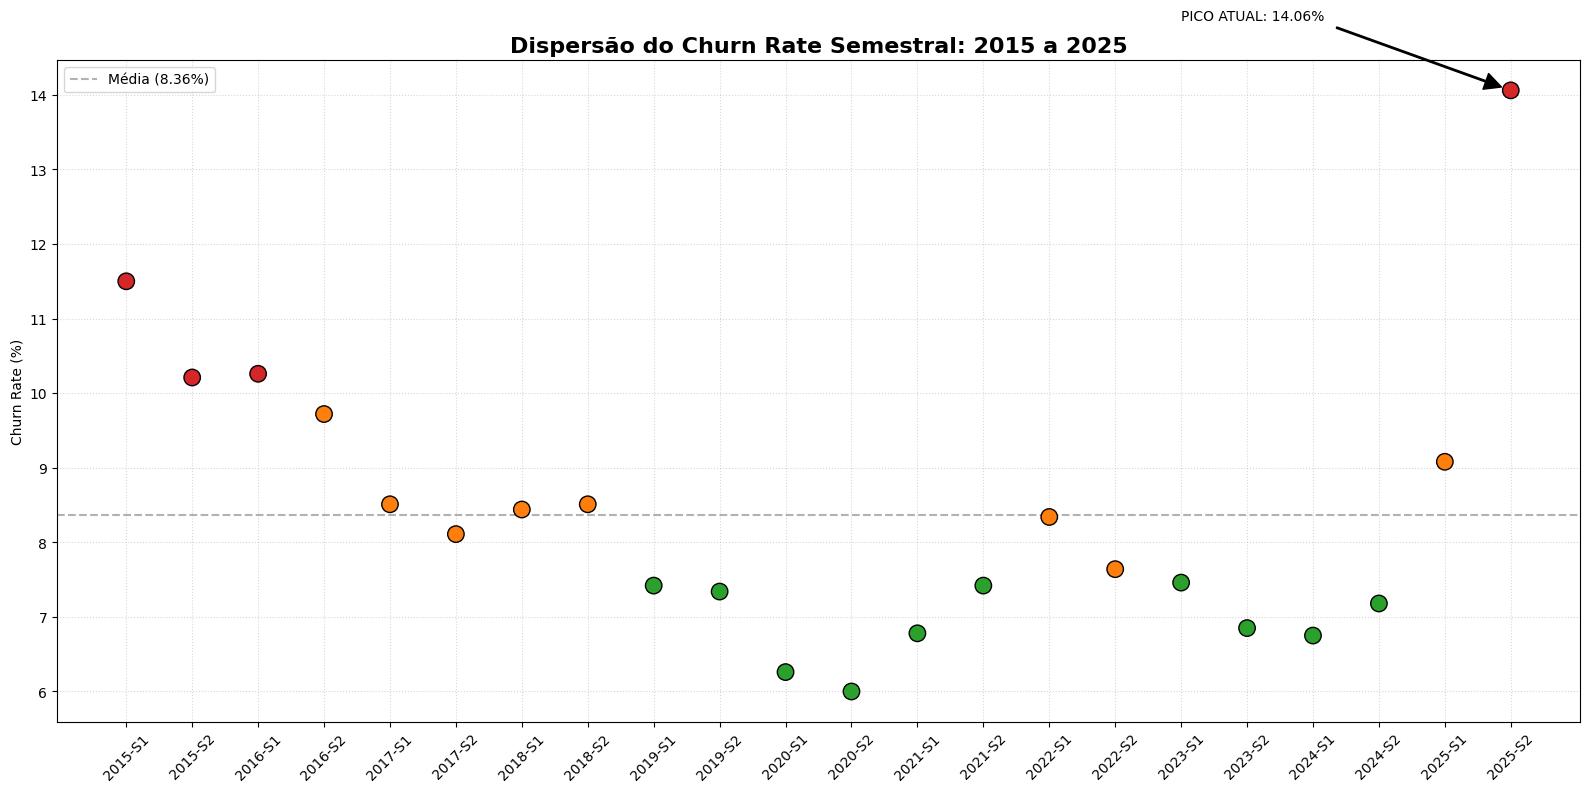

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carregando os dados exatamente como na sua imagem
data = {
    'periodo_semestral': [
        '2015-S1', '2015-S2', '2016-S1', '2016-S2', '2017-S1', '2017-S2',
        '2018-S1', '2018-S2', '2019-S1', '2019-S2', '2020-S1', '2020-S2',
        '2021-S1', '2021-S2', '2022-S1', '2022-S2', '2023-S1', '2023-S2',
        '2024-S1', '2024-S2', '2025-S1', '2025-S2'
    ],
    'churn_rate': [
        11.50, 10.21, 10.26, 9.72, 8.51, 8.11, 8.44, 8.51, 7.42, 7.34,
        6.26, 6.00, 6.78, 7.42, 8.34, 7.64, 7.46, 6.85, 6.75, 7.18, 9.08, 14.06
    ],
    'analise_saude': [
        'CRÍTICO (>12%)', 'CRÍTICO (>12%)', 'CRÍTICO (>12%)', 'ALERTA', 'ALERTA', 'ALERTA',
        'ALERTA', 'ALERTA', 'DENTRO DA META', 'DENTRO DA META', 'DENTRO DA META', 'DENTRO DA META',
        'DENTRO DA META', 'DENTRO DA META', 'ALERTA', 'ALERTA', 'DENTRO DA META', 'DENTRO DA META',
        'DENTRO DA META', 'DENTRO DA META', 'ALERTA', 'CRÍTICO (>12%)'
    ]
}

df_final = pd.DataFrame(data)

# 2. Configurando as cores baseadas no status de saúde
cores_map = {
    'DENTRO DA META': '#2ca02c', # Verde
    'ALERTA': '#ff7f0e',         # Laranja
    'CRÍTICO (>12%)': '#d62728'   # Vermelho
}
cores = df_final['analise_saude'].map(cores_map)

# 3. Criando o gráfico
plt.figure(figsize=(16, 8))
plt.scatter(df_final['periodo_semestral'], df_final['churn_rate'], c=cores, s=140, edgecolors='black', zorder=3)

# Linha da Média Histórica
plt.axhline(y=8.36, color='gray', linestyle='--', alpha=0.6, label='Média (8.36%)')

# Estilização
plt.title('Dispersão do Churn Rate Semestral: 2015 a 2025', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Churn Rate (%)')
plt.grid(True, linestyle=':', alpha=0.5)

# Destacar o ponto atual
plt.annotate(f'PICO ATUAL: 14.06%', xy=('2025-S2', 14.06), xytext=('2023-S1', 15),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1))

plt.legend()
plt.tight_layout()
plt.show()

In [14]:
df_churn_semestral.columns

Index(['periodo_semestral', 'clientes_inicio_semestre',
       'total_churn_no_semestre', 'churn_rate_semestral_percentual',
       'analise_saude', 'variacao_percentual'],
      dtype='object')

# 📉 Diagnóstico Estratégico de Churn  
**Análise Semestral (2015–2025)**

---

## 1. O Ponto de Ruptura — *2025-S2*

O gráfico de dispersão evidencia um **evento extremo na série histórica**:  
o churn de **14,06% em 2025-S2** representa o **maior valor desde 2015**, caracterizando um claro **ponto de ruptura operacional**.

### 🔴 Superação do Recorde Histórico
- **Pior semestre anterior:** 2015-S1 (11,50%)
- **Churn atual:** 14,06%
- **Aumento absoluto:** +2,56 p.p. sobre o antigo pico

Esse salto invalida qualquer hipótese de variação normal ou sazonal.

### 📊 Desvio Crítico da Normalidade
- **Média histórica:** 8,36%
- **Era de estabilidade (2019–2024):** churn entre 6% e 7%
- **2025:** quebra abrupta do padrão histórico

➡️ O churn atual está **estatisticamente e operacionalmente fora do regime normal** da empresa.

---

## 2. A Armadilha do Crescimento

A análise da variável `clientes_inicio_semestre` revela um padrão clássico — e perigoso — de **crescimento acelerado**.

### 🚀 Expansão Agressiva da Base
- **2024-S2:** 6.853 clientes  
- **2025-S1:** 9.581 clientes  
- **Crescimento:** ~40% em apenas 6 meses  

Esse ritmo é altamente incomum quando comparado à trajetória histórica da empresa.

### ⚠️ Impacto Direto no Churn
- **Saídas em 2024-S2:** 492 clientes  
- **Saídas em 2025-S2:** 1.326 clientes  

O churn elevado de 2025-S2 parece ser o **efeito retardado** do crescimento desordenado ocorrido em 2025-S1.

📌 **Hipótese central:**  
> O crescimento acelerado atraiu clientes fora do *Product-Market Fit* ou sobrecarregou processos críticos (onboarding, suporte e Customer Success).

---

## 3. Evolução da Saúde da Retenção (Visão Semestral)

O gráfico de linhas permite segmentar a história da retenção em **três fases distintas**:

### 🔴 2015–2018 — *Fase Instável*
- Churn elevado e altamente volátil  
- Frequente permanência em zonas de **Alerta** ou **Crítico**  
- Operação reativa, com baixa previsibilidade  

### 🟢 2019–2024 — *Fase de Eficiência*
- Longo período de estabilidade operacional  
- Churn consistentemente **Dentro da Meta**  
- **Mínima histórica:** 6,00% em 2020-S2  
- Indícios claros de maturidade em produto, preço e atendimento  

### 🔥 2025 — *Fase de Crise*
- Escalada abrupta e contínua  
- **7,18% → 14,06% em apenas 12 meses**  
- Perda total do padrão de controle observado nos anos anteriores  

➡️ Trata-se de uma **mudança estrutural**, não de um desvio pontual.

---

## 4. Diagnóstico Central

O ponto-chave da análise **não é apenas o aumento do churn**, mas sim a pergunta estratégica:

> **Por que o volume recorde de clientes adquiridos em 2025-S1 não permaneceu na empresa?**

Responder essa pergunta é essencial para:
- Estancar a crise  
- Corrigir o modelo de crescimento  
- Evitar reincidência do problema  

---

## 5. Próximos Passos Recomendados (Investigação Analítica)

### 🔍 1. Análise de Coorte (*Cohort Analysis*)
- Segmentar clientes por semestre de entrada  
- Verificar se o churn de 14% está concentrado na coorte **2025-S1**

📌 **Interpretação:**
- Churn concentrado na coorte nova → falha em marketing/vendas (perfil errado)  
- Churn distribuído → problema sistêmico  

---

### 🧩 2. Análise de Produto e Preço
- Avaliar se clientes antigos também aumentaram o churn  
- Investigar mudanças em:
  - Produto  
  - Precificação  
  - Contratos  
  - Experiência do usuário  

📌 Se clientes maduros estão saindo, o problema **não é aquisição**, é **valor percebido**.

---

### 🧑‍💼 3. Capacidade de Atendimento (*Customer Success*)
- **Crescimento de saídas:** +169% (492 → 1.326)
- Avaliar:
  - Dimensionamento do time de CS  
  - SLA de atendimento  
  - Qualidade do onboarding  

📌 Um time subdimensionado transforma crescimento em churn.

---

## 🎯 Conclusão Executiva

O churn de **2025-S2 não é um acidente**.  
Ele é o **resultado acumulado de decisões de crescimento sem sustentação operacional**.

> **Crescer sem retenção não é escala — é vazamento.**

A próxima etapa analítica deve focar em **coortes, valor entregue e capacidade operacional**, criando as bases para um crescimento saudável e sustentável.
